In [35]:
import numpy as np
import pandas as pd

In [36]:
data = pd.read_csv(r"IMDB Dataset.csv")

In [37]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [38]:
data.shape

(50000, 2)

In [39]:
data.size

100000

In [40]:
data.columns

Index(['review', 'sentiment'], dtype='object')

In [41]:
data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [42]:
data['review'].value_counts()

review
Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stimulating and captivating, always keeping the viewer peeking around the corner to see what was coming up next. She is as down to earth and as personable as you get, like one of us which made the show all the more enjoyable. Special guests, who are friends as well made for a nice surprise too. Loved the 'first' theme and that the audience was invited to play along too. I must admit I was shocked to see her come in under her time limits on a few things, but she did it and by golly I'll be writing those recipes down. Saving time in the kitchen means more time with family. Those who haven't tuned in yet, find out what channel and the time, I assure you that you won't be disappointed.                                                                                                                                                                                                         

In [43]:
import sqlite3

# Connect to SQLite (or create a new database)
conn = sqlite3.connect('imdb_reviews.db')
cursor = conn.cursor()

# Create the table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS imdb_reviews (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        review_text TEXT,
        sentiment TEXT
    )
''')

# Insert data
for _, row in data.iterrows():
    cursor.execute('INSERT INTO imdb_reviews (review_text, sentiment) VALUES (?, ?)', (row['review'], row['sentiment']))

conn.commit()
conn.close()


In [44]:
conn = sqlite3.connect('imdb_reviews.db')
df_from_db = pd.read_sql_query('SELECT * FROM imdb_reviews LIMIT 5', conn)
print(df_from_db)
conn.close()


   id                                        review_text sentiment
0   1  One of the other reviewers has mentioned that ...  positive
1   2  A wonderful little production. <br /><br />The...  positive
2   3  I thought this was a wonderful way to spend ti...  positive
3   4  Basically there's a family where a little boy ...  negative
4   5  Petter Mattei's "Love in the Time of Money" is...  positive


In [45]:
import re

def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

data['cleaned_review'] = data['review'].apply(clean_text)
print(data['cleaned_review'].head())


0    one of the other reviewers has mentioned that ...
1    a wonderful little production the filming tech...
2    i thought this was a wonderful way to spend ti...
3    basically theres a family where a little boy j...
4    petter matteis love in the time of money is a ...
Name: cleaned_review, dtype: object


In [46]:
# Sentiment distribution
print(data['sentiment'].value_counts())

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [47]:
# Average review length per sentiment
data['review_length'] = data['cleaned_review'].apply(len)
print(data.groupby('sentiment')['review_length'].mean())

sentiment
negative    1227.88956
positive    1261.39924
Name: review_length, dtype: float64


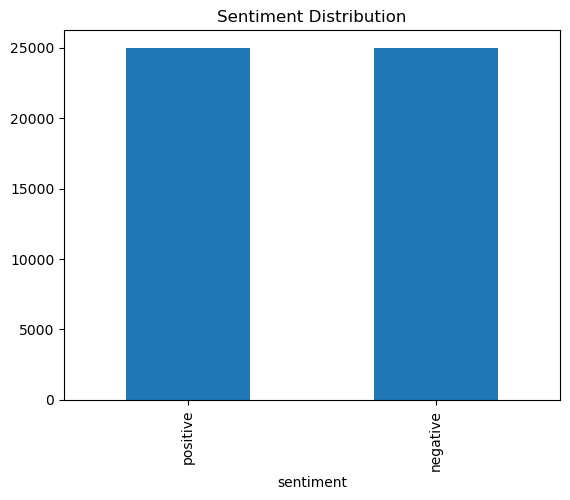

In [48]:
# Visualization (optional)
import matplotlib.pyplot as plt

data['sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution')
plt.show()

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['cleaned_review'], data['sentiment'], test_size=0.2, random_state=42)

# TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [50]:
vectorizer

TfidfVectorizer(max_features=10000)

In [51]:
X_train_tfidf

<40000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 4859873 stored elements in Compressed Sparse Row format>

In [52]:
X_test_tfidf

<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 1218082 stored elements in Compressed Sparse Row format>

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Evaluation
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      4961
    positive       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Accuracy: 0.8963


In [62]:
model

LogisticRegression()

In [64]:
y_pred

array(['negative', 'positive', 'negative', ..., 'positive', 'negative',
       'positive'], dtype=object)

In [70]:
y_test.size

10000

In [71]:
y_train.size

40000

In [67]:
y_train.size

40000

In [33]:
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Example: Train a simple Logistic Regression model
data = pd.read_csv("IMDB Dataset.csv")

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

data['cleaned_review'] = data['review'].apply(clean_text)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(data['cleaned_review'])
y = data['sentiment']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Save model and vectorizer
with open('sentiment_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

print("Model and vectorizer saved!")


Model and vectorizer saved!


In [34]:
data.head()

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love in the time of money is a ...


In [72]:
data.size

200000